In [2]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from pathlib import Path
from scipy.io import savemat, loadmat
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [5]:
SAMPLING_RATE = 128
N_SAMPLES_PER_EPOCH = 5 * SAMPLING_RATE

def get_data_files():
    files = list(Path('../data').glob('*.mat'))
    return files

def bis_to_groups(bis):
    if bis < 40 and bis >= 0:
        return '0-40'
    elif bis >= 40 and bis < 65:
        return '40-65'
    elif bis >= 65 and bis < 85:
        return '65-85'
    elif bis >= 85 and bis <= 100:
        return '85-100'

def mat_to_df(file):
    data = loadmat(file)
    eeg_data = data['EEG'].flatten()
    bis_data = data['bis'].flatten()
    bis_mapped = list(map(bis_to_groups, bis_data[bis_data != -1][:len(eeg_data)//N_SAMPLES_PER_EPOCH]))
    eeg_epochs = eeg_data[:len(bis_mapped)*N_SAMPLES_PER_EPOCH].reshape(len(bis_mapped), N_SAMPLES_PER_EPOCH)
    df = pd.DataFrame(eeg_epochs)
    df['bis'] = bis_mapped
    return df

def get_all_data():
    return pd.concat([mat_to_df(file) for file in get_data_files()])

def standardize_data(x_train,x_valid, x_test):
    scaler = StandardScaler()
    scaler.fit(np.concatenate([x_train, x_valid]))
    x_train, x_valid, x_test = [scaler.transform(x).reshape(-1, N_SAMPLES_PER_EPOCH, 1) for x in [x_train, x_valid, x_test]]
    return x_train, x_valid, x_test

def save_test_data(x_test, y_test, model_name):
    np.savez(f'./test_data/{model_name}.npz', x_test=x_test, y_test=y_test)

def load_test_data(model_name):
    loaded_data = np.load(f'./test_data/{model_name}.npz', allow_pickle=True)
    x_test_loaded = loaded_data['x_test']
    y_test_loaded = loaded_data['y_test']
    return x_test_loaded, y_test_loaded

In [4]:
def make_binary_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def compile_binary_model(model):
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')
                 ]
    )
    return model

def get_class_weights(y_train):
    y_train_flat = np.ravel(y_train)

    class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_flat),
    y=y_train_flat
    )
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
    print("Class Weights:", class_weights_dict)
    return class_weights_dict


def fit_model(model, model_name,  x_train, y_train, x_valid, y_valid, epochs=100, balanced=False):
    class_weights_dict = get_class_weights(y_train) if balanced else None
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"./models/{model_name}.keras", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
        ),
        keras.callbacks.CSVLogger(
            f"./training_csv/{model_name}_training.csv", separator=",", append=False)
    ]
    
    model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )


def evaluate_model(model, model_name, x_test, y_test):
    results = model.evaluate(x_test, y_test, verbose=2, return_dict=True)
    df = pd.DataFrame([results])
    df.to_csv(f"./evals/{model_name}_eval.csv")


def plot_binary_confusion_matrix(model, model_name, X_test, y_test, target_names=['0','1'], normalize=False):
    y_predicted = (model.predict(X_test) >= 0.5).astype(int).flatten()

    label_mapping = {0: target_names[0], 1: target_names[1]}
    y_test_labels = pd.Series(y_test.flatten()).map(label_mapping).values
    y_predicted_labels = pd.Series(y_predicted.flatten()).map(label_mapping).values

    cm = confusion_matrix(y_test_labels, y_predicted_labels, labels=[target_names[1], target_names[0]], normalize='true' if normalize else None)
    report = classification_report(y_test_labels, y_predicted_labels, output_dict=True, target_names=[target_names[1], target_names[0]])
    print(report)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d' if not normalize else '.2f', cmap='Blues',
                xticklabels=[target_names[1], target_names[0]],  
                yticklabels=[target_names[1], target_names[0]]) 
    plt.xlabel('Predicted')
    plt.ylabel('True')
    cm_path = f'./CM_figs_norm/{model_name}_CM.png' if normalize else f'./CMs/{model_name}_CM.png'
    plt.savefig(cm_path)
    plt.show()


def convert_to_binary(y, positive_class):
    y = y.copy()
    y_mapped = np.array(y == positive_class).astype(int).reshape(-1, 1)
    return y_mapped


def get_BC_training_data(positive_class, negative_class):
    df = get_all_data()
    filtered_df = df[(df['bis'] == positive_class) | (df['bis'] == negative_class)]
    train, validate, test =  np.split(filtered_df.sample(frac=1, random_state=42), [int(0.7*len(filtered_df)), int(0.85*len(filtered_df))])
    x_train, x_valid, x_test = standardize_data(*[df.drop('bis', axis=1).to_numpy() for df in [train, validate, test]])
    y_train, y_valid, y_test = [df['bis'].to_numpy() for df in [train, validate, test]]

    print(f"Train: {x_train.shape} {y_train.shape}")
    print(f"Valid: {x_valid.shape} {y_valid.shape}")
    print(f"Test: {x_test.shape} {y_test.shape}")

    return x_train, x_valid, x_test, y_train, y_valid, y_test

def oVo_classification(bis1, bis2, epochs=100,balanced=False):
    balance = "balanced" if balanced else "unbalanced"
    model_name = f"{bis1}_VS_{bis2}_{balance}_{epochs}e"
    x_train, x_valid, x_test, y_train_og, y_valid_og, y_test_og = get_BC_training_data(bis1, bis2)
    save_test_data(x_test, y_test_og, model_name)
    y_train, y_valid, y_test = [convert_to_binary(y, bis1) for y in [y_train_og, y_valid_og, y_test_og]]

    model = compile_binary_model(make_binary_model(x_train.shape[1:]))
    fit_model(model, model_name, x_train, y_train, x_valid, y_valid, epochs=epochs, balanced=balanced)

    model = keras.models.load_model(f"./models/{model_name}.keras")
    evaluate_model(model, model_name, x_test, y_test)
    plot_binary_confusion_matrix(
        model, model_name, x_test, y_test, target_names=[bis2, bis1])
    
def get_one_vs_all_data():
    df = get_all_data()
    train, validate, test =  np.split(df.sample(frac=1, random_state=42), [int(0.7*len(df)), int(0.85*len(df))])
    x_train, x_valid, x_test = standardize_data(*[df.drop('bis', axis=1).to_numpy() for df in [train, validate, test]])
    y_train, y_valid, y_test = [df['bis'].to_numpy() for df in [train, validate, test]]

    print(f"Train: {x_train.shape} {y_train.shape}")
    print(f"Valid: {x_valid.shape} {y_valid.shape}")
    print(f"Test: {x_test.shape} {y_test.shape}")

    return x_train, x_valid, x_test, y_train, y_valid, y_test

def one_vs_all_classification(bis, epochs=100, balanced=False):
    balance = "balanced" if balanced else "unbalanced"
    model_name = f"{bis}_VS_ALL_{balance}_{epochs}e"
    x_train, x_valid, x_test, y_train_og, y_valid_og, y_test_og = get_one_vs_all_data()
    save_test_data(x_test, y_test_og, model_name)
    y_train, y_valid, y_test = [convert_to_binary(y, bis) for y in [y_train_og, y_valid_og, y_test_og]]

    model = compile_binary_model(make_binary_model(x_train.shape[1:]))
    fit_model(model, model_name, x_train, y_train, x_valid, y_valid, epochs=epochs, balanced=balanced)

    model = keras.models.load_model(f"./models/{model_name}.keras")
    evaluate_model(model, model_name, x_test, y_test)
    plot_binary_confusion_matrix(
        model, model_name, x_test, y_test, target_names=['All', bis])


In [ ]:
oVo_classification('0-40', '40-65', epochs=100, balanced=False)
oVo_classification('0-40', '65-85', epochs=100, balanced=False)
oVo_classification('0-40', '85-100', epochs=100, balanced=False)
oVo_classification('40-65', '65-85', epochs=100, balanced=False)
oVo_classification('40-65', '85-100', epochs=100, balanced=False)
oVo_classification('65-85', '85-100', epochs=100, balanced=False)

In [ ]:
oVo_classification('0-40', '40-65', epochs=100, balanced=True)
oVo_classification('0-40', '65-85', epochs=100, balanced=True)
oVo_classification('0-40', '85-100', epochs=100, balanced=True)
oVo_classification('40-65', '65-85', epochs=100, balanced=True)
oVo_classification('40-65', '85-100', epochs=100, balanced=True)
oVo_classification('65-85', '85-100', epochs=100, balanced=True)

In [ ]:
one_vs_all_classification('0-40', epochs=100, balanced=True)
one_vs_all_classification('40-65', epochs=100, balanced=True)
one_vs_all_classification('65-85', epochs=100, balanced=True)
one_vs_all_classification('85-100', epochs=100, balanced=True)

In [ ]:
one_vs_all_classification('0-40', epochs=100, balanced=False)
one_vs_all_classification('40-65', epochs=100, balanced=False)
one_vs_all_classification('65-85', epochs=100, balanced=False)
one_vs_all_classification('85-100', epochs=100, balanced=False)

Processing model: 0-40_VS_ALL_unbalanced_100e
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report for 0-40_VS_ALL_unbalanced_100e:
               precision    recall  f1-score   support

        0-40      0.813     0.855     0.833      2320
         ALL      0.868     0.830     0.849      2681

    accuracy                          0.841      5001
   macro avg      0.841     0.842     0.841      5001
weighted avg      0.843     0.841     0.841      5001

Processing model: 40-65_VS_ALL_unbalanced_100e
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report for 40-65_VS_ALL_unbalanced_100e:
               precision    recall  f1-score   support

       40-65      0.762     0.723     0.742      2065
         ALL      0.812     0.842     0.826      2936

    accuracy                          0.792      5001
   macro avg      0.787     0.782     0.784      5001
weighted avg      0.791     0.792     0.792      5001

Processing model: 65-85_VS_ALL_unbalanced_100e
157/157 ━

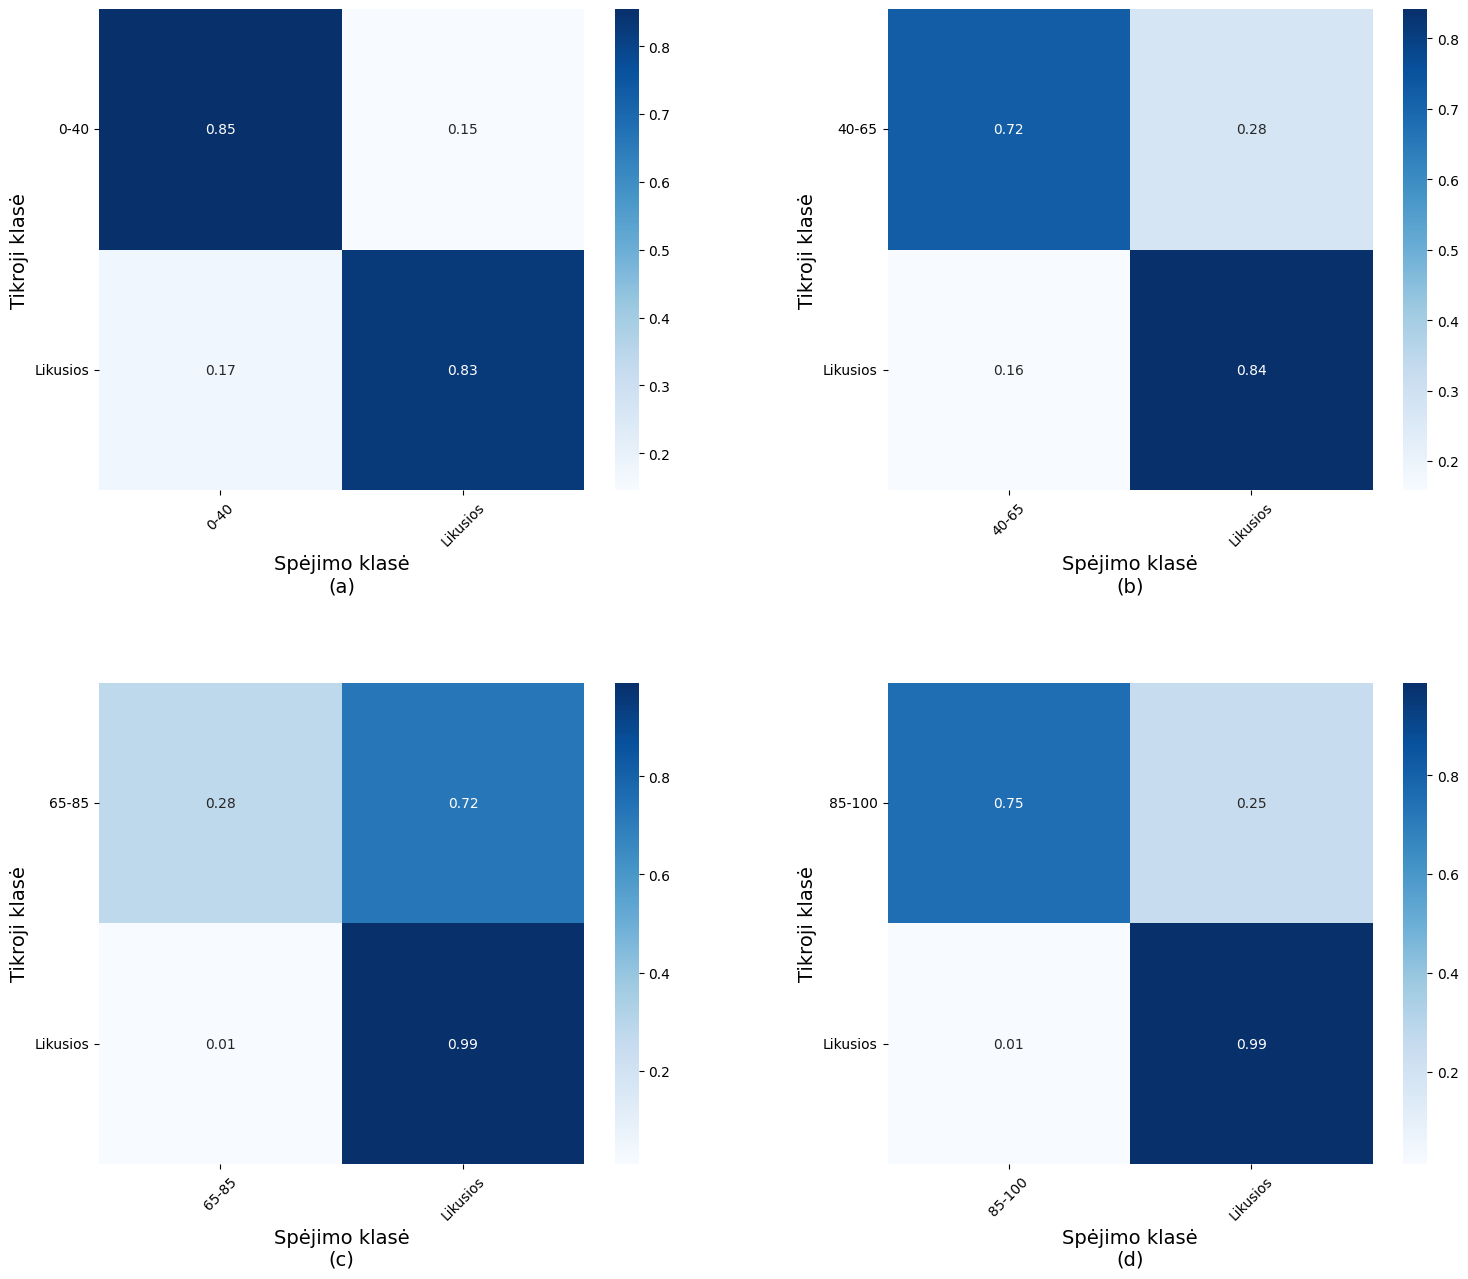

Processing model: 0-40_VS_ALL_balanced_100e
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Classification Report for 0-40_VS_ALL_balanced_100e:
               precision    recall  f1-score   support

        0-40      0.815     0.845     0.830      2355
         ALL      0.858     0.830     0.843      2646

    accuracy                          0.837      5001
   macro avg      0.837     0.837     0.837      5001
weighted avg      0.838     0.837     0.837      5001

Processing model: 40-65_VS_ALL_balanced_100e
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Classification Report for 40-65_VS_ALL_balanced_100e:
               precision    recall  f1-score   support

       40-65      0.750     0.786     0.767      2095
         ALL      0.840     0.811     0.825      2906

    accuracy                          0.800      5001
   macro avg      0.795     0.798     0.796      5001
weighted avg      0.802     0.800     0.801      5001

Processing model: 65-85_VS_ALL_balanced_100e
157/157 ━━━━━━━━━━━

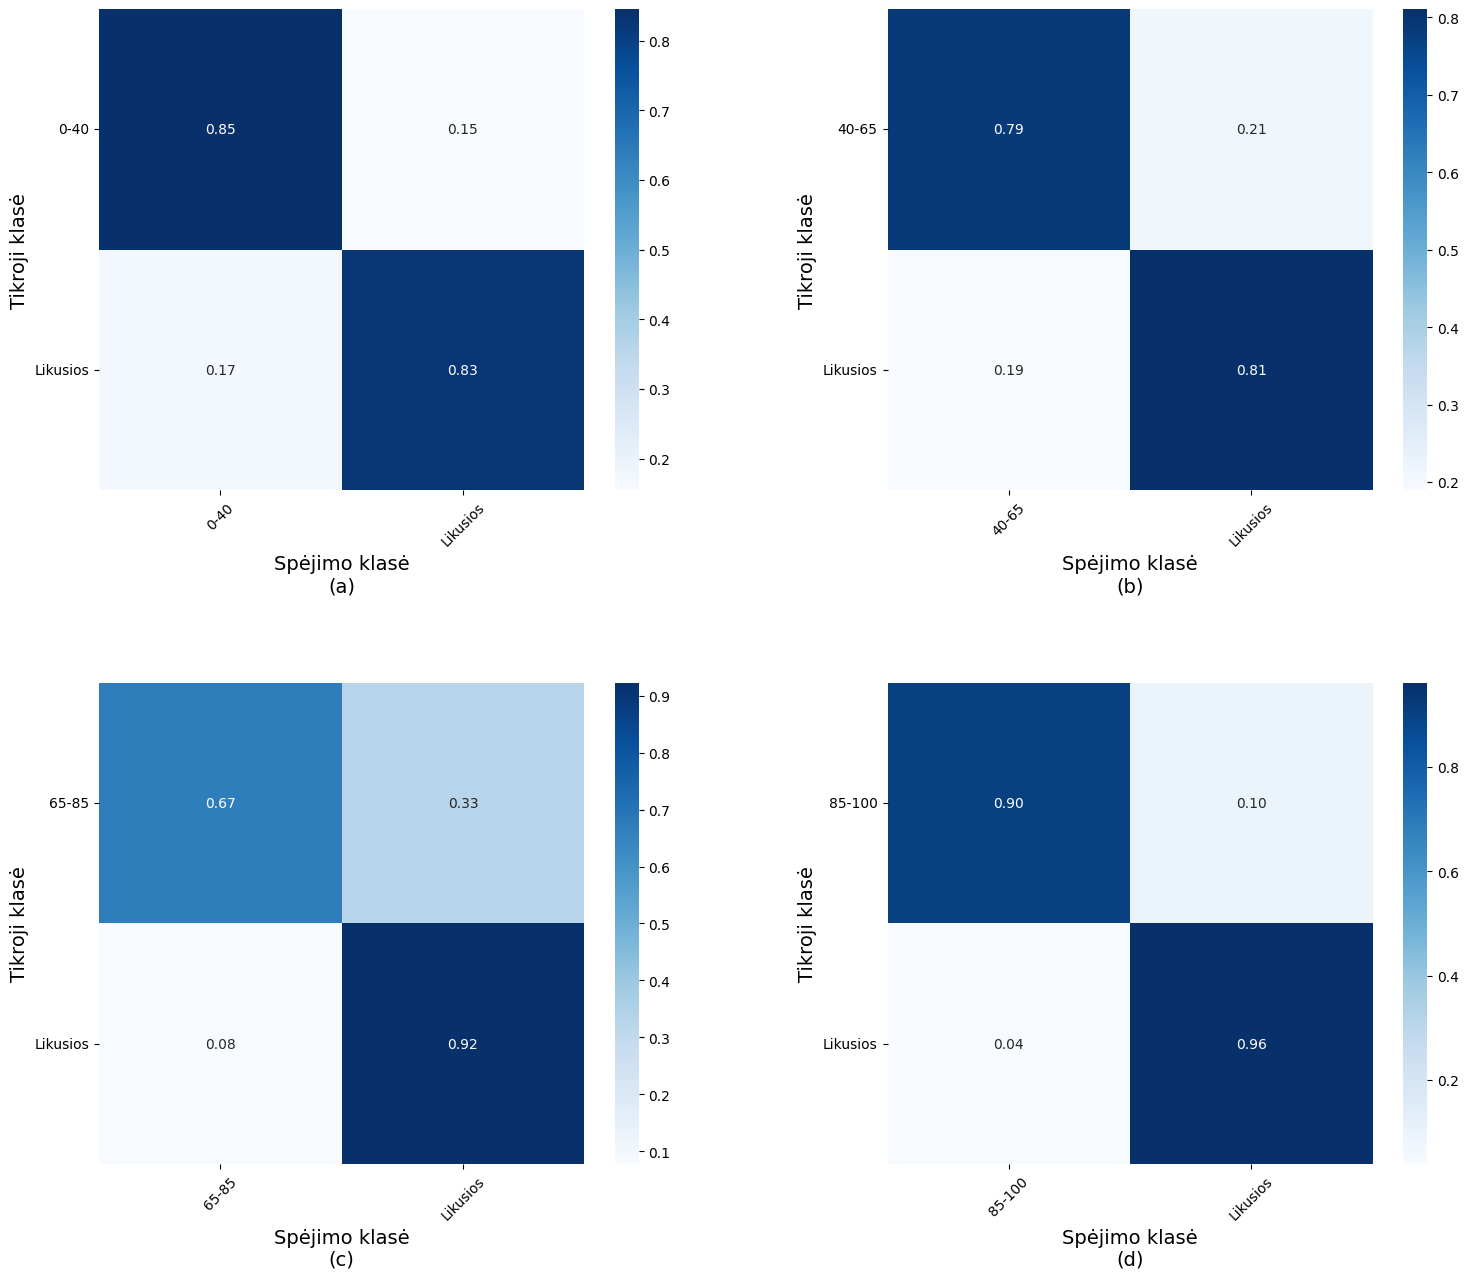

Processing model: 0-40_VS_40-65_unbalanced_100e
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Classification Report for 0-40_VS_40-65_unbalanced_100e:
               precision    recall  f1-score   support

        0-40      0.828     0.847     0.837      2315
       40-65      0.826     0.805     0.815      2091

    accuracy                          0.827      4406
   macro avg      0.827     0.826     0.826      4406
weighted avg      0.827     0.827     0.827      4406

Processing model: 0-40_VS_65-85_unbalanced_100e
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report for 0-40_VS_65-85_unbalanced_100e:
               precision    recall  f1-score   support

        0-40      0.980     0.987     0.984      2341
       65-85      0.883     0.831     0.856       272

    accuracy                          0.971      2613
   macro avg      0.932     0.909     0.920      2613
weighted avg      0.970     0.971     0.971      2613

Processing model: 0-40_VS_85-100_unbalanced_100e
82/

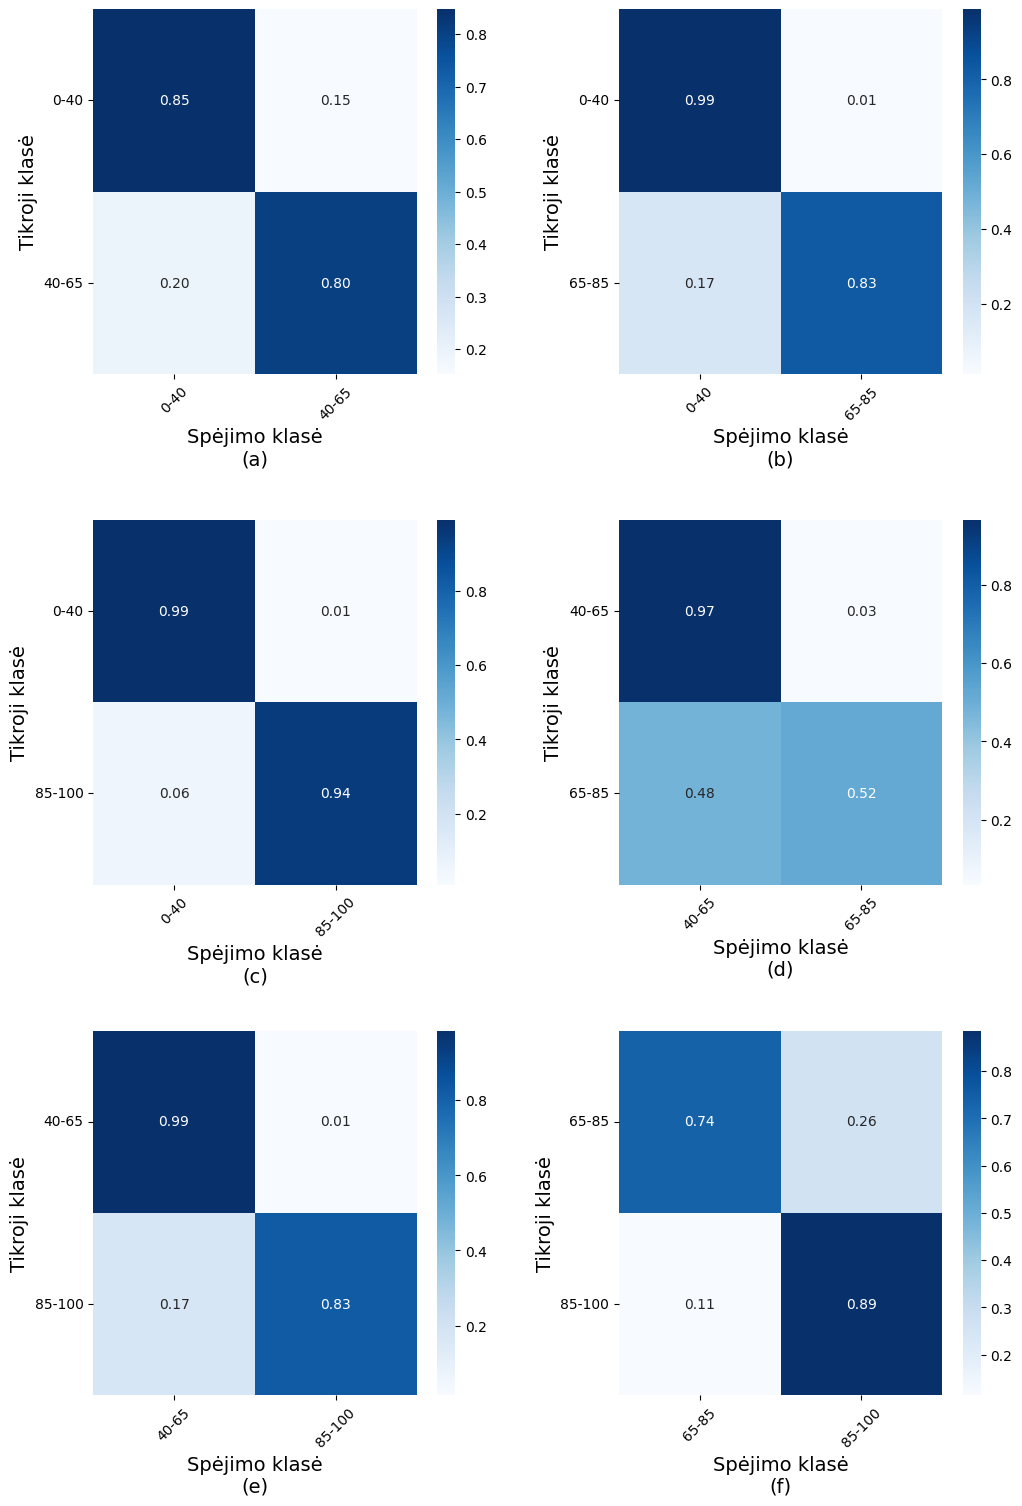

Processing model: 0-40_VS_40-65_balanced_100e
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Classification Report for 0-40_VS_40-65_balanced_100e:
               precision    recall  f1-score   support

        0-40      0.816     0.822     0.819      2091
       40-65      0.838     0.832     0.835      2315

    accuracy                          0.827      4406
   macro avg      0.827     0.827     0.827      4406
weighted avg      0.827     0.827     0.827      4406

Processing model: 0-40_VS_65-85_balanced_100e
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report for 0-40_VS_65-85_balanced_100e:
               precision    recall  f1-score   support

        0-40      0.888     0.843     0.865       293
       65-85      0.980     0.987     0.983      2320

    accuracy                          0.971      2613
   macro avg      0.934     0.915     0.924      2613
weighted avg      0.970     0.971     0.970      2613

Processing model: 0-40_VS_85-100_balanced_100e
82/82 ━━━━━━━

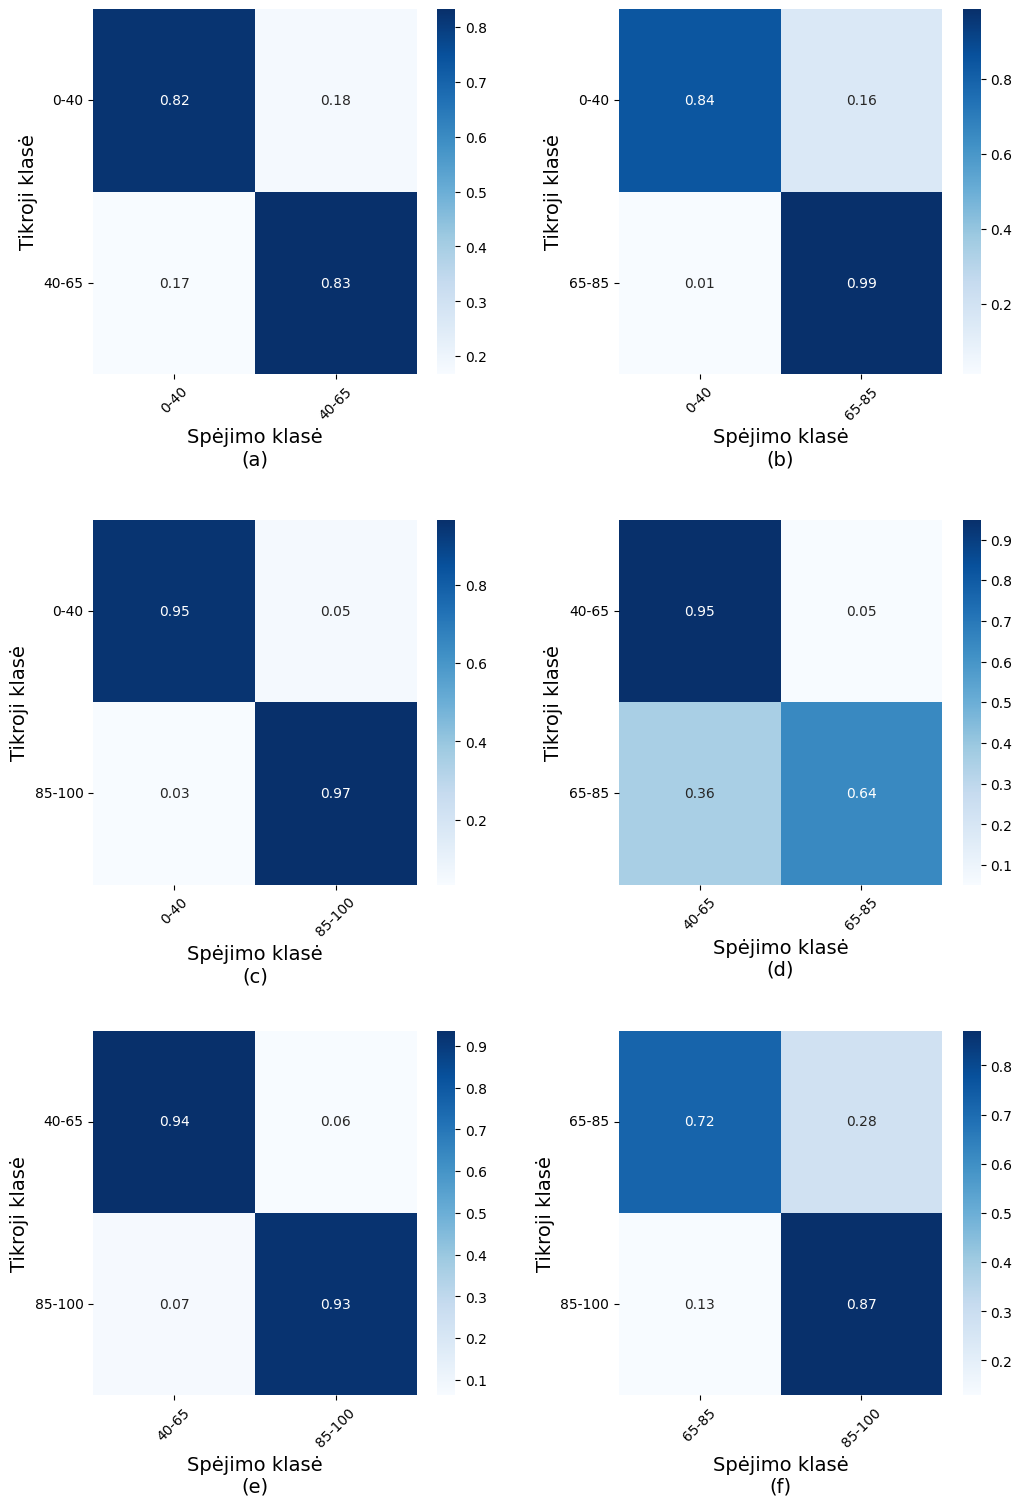

In [15]:
def plot_final_CM(model_names):
    all_cms = []
    titles = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

    for model_name in model_names:
        print(f"Processing model: {model_name}")

        model = keras.models.load_model(f"./models/{model_name}.keras")
        x_test, y_test = load_test_data(model_name)
        negative_class = model_name.split('_')[2]
        positive_class = model_name.split('_')[0]
        y_test = convert_to_binary(y_test, positive_class)
        y_predicted = (model.predict(x_test) >= 0.5).astype(int).flatten()
        label_mapping = {0: negative_class, 1: positive_class}
        labels = [positive_class, negative_class]
        y_test_labels = pd.Series(y_test.flatten()).map(label_mapping).values
        y_predicted_labels = pd.Series(y_predicted.flatten()).map(label_mapping).values

        cm = confusion_matrix(y_test_labels, y_predicted_labels, labels=labels, normalize='true')
        report = classification_report(y_test_labels, y_predicted_labels, output_dict=False, digits=3)
        print(f"Classification Report for {model_name}:\n", report)
        all_cms.append((cm, labels))

    figsize = (18,15) if len(model_names) == 4 else (12,18)
    fig, axes = plt.subplots(len(model_names)//2, 2, figsize=figsize) 
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    for ax, (cm, klases), title in zip(axes.flatten(), all_cms, titles):
        klases = ['Likusios' if k == 'ALL' else k for k in klases]
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=klases, yticklabels=klases, ax=ax)
        ax.set_xlabel(f'Spėjimo klasė\n{title}', fontsize=14) 
        ax.set_ylabel('Tikroji klasė', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    plt.show()


oVa_unbalanced = ['0-40_VS_ALL_unbalanced_100e', '40-65_VS_ALL_unbalanced_100e', '65-85_VS_ALL_unbalanced_100e', '85-100_VS_ALL_unbalanced_100e']
oVa_balanced = ['0-40_VS_ALL_balanced_100e', '40-65_VS_ALL_balanced_100e', '65-85_VS_ALL_balanced_100e', '85-100_VS_ALL_balanced_100e']
oVo_unbalanced = ['0-40_VS_40-65_unbalanced_100e', '0-40_VS_65-85_unbalanced_100e', '0-40_VS_85-100_unbalanced_100e', '40-65_VS_65-85_unbalanced_100e', '40-65_VS_85-100_unbalanced_100e', '65-85_VS_85-100_unbalanced_100e']
oVo_balanced = ['0-40_VS_40-65_balanced_100e', '0-40_VS_65-85_balanced_100e', '0-40_VS_85-100_balanced_100e', '40-65_VS_65-85_balanced_100e', '40-65_VS_85-100_balanced_100e', '65-85_VS_85-100_balanced_100e']

for models in [oVa_unbalanced, oVa_balanced, oVo_unbalanced, oVo_balanced]:
    plot_final_CM(models)